<h1>Analysis - Design of the Viseu Aerodrome runway</h1>
<br> This file contains the functions developed for this study, the results and the data analysis.

<h2>Basic info</h2>

© Tiago Tamagusko (tamagusko@gmail.com) - <a href="https://tamagusko.github.io">https://tamagusko.github.io</a>
<br> Version: 0.5 (28/12/2019)
<br> Using: Jupyter Notebook 6.0.2, Python 3.8, Linux 4.19.88-1-MANJARO x64, UTF-8.
<br> Required libraries: pandas 0.25.3, matplotlib 3.1.1, sys 3.8.0, geopandas 0.6.2, descartes 1.1.0, mplleaflet 0.0.5.
<br> Project Page: <a href="https://github.com/tamagusko/ViseuAirportStudy">github.com/tamagusko/ViseuAirportStudy</a>
<br> Licence: Apache-2.0, see <a href="/LICENSE.md">LICENSE.md</a> for more details.


<h2>Problem</h2>

Viseu Aerodrome is interested in servicing bigger aircraft, which enable longer range and carry more passengers per aircraft [1]. This requires improving the structural strength of the pavement and increasing the length of its runway.

<h2>Proposal</h2>

In order to design an airport pavement, it is necessary to know two main characteristics, namely the Pavement Classification Number¹ (PCN) and the extension of the runway.

Thus, the proposed challenge is to design a pavement with capacity (PCN) and extension to meet a desired group of routes.

<h2>Project data structure</h2>
    
    ├── 1-preprocessing.ipyng    # Database preprocessing 
    ├── 2-analysis.ipynb               # Data analysis
    ├── data                  
    │          ├── raw                       # Raw data
    │          ├── processed           # Data processed
    ├── reports                              # Outputs
    

Notes: 

**¹** Indicates, among other elements, the structural strength of the pavement. <br>

<h3> Go to <a href="/1-preprocessing.ipyng">1-preprocessing.ipyng</a> to view data preparation and processing </h3>

<h1>3. Loading databases</h1>

In [1]:
#import needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install mplleaflet
import geopandas as gpd
from shapely.geometry import Point
import mplleaflet
from datetime import datetime
import os

# Reference airport, change this value (RefAirportICAO) to choose another airport
RefAirportICAO = "LPVZ"

In [2]:
# Reading data

# Database developed by the author
aircrafts = pd.read_csv("data/processed/AircraftData.csv", sep=",", index_col ="Aircraft")

# Preprocessed database (see 1-preprocessing.ipyng)
airports = pd.read_csv("reports/AirportProcessedData.csv", sep=",", index_col ="ICAO")

In [3]:
# Resulting dataframe Aircraft,ACN,RequiredExtension,Autonomy,Passagers
aircrafts  # Printing the data to test

,ACN,RequiredExtension,Autonomy,Passagers
Aircraft,,,,
Dornier_228,6.4,792,1037,19
DCH-8_Q200,16.5,1000,2084,40
ATR42-600,18.6,1165,1326,48
ERJ140,21.1,1850,3058,44
ATR72-600,23.0,1175,1528,72
CRJ200,23.0,1768,2500,50
DCH-8_Q400,30.5,1425,2040,82
CRJ700,34.0,1605,2553,70
E170,38.6,1644,3982,72


In [4]:
# Resulting dataframe ICAO,Airport,City,Country,Latitude,Longitude,Altitude,DistanceToRef,RWYLenght,PCN
airports.head(5) # Printing the data to test

,Airport,City,Country,Latitude,Longitude,Altitude,DistanceToRef,RWYLenght,PCN
ICAO,,,,,,,,,
BIKF,Keflavik International Airport,Keflavik,Iceland,63.985001,-22.60560,171.0,2759.7,3065.0,80.0
EBBR,Brussels Airport,Brussels,Belgium,50.901402,4.48444,184.0,1480.6,3638.0,80.0
EBCI,Brussels South Charleroi Airport,Charleroi,Belgium,50.459202,4.45382,614.0,1444.6,2550.0,64.0
EDDB,Berlin-Schönefeld Airport,Berlin,Germany,52.380001,13.52250,157.0,2077.9,3000.0,140.0
EDDK,Cologne Bonn Airport,Cologne,Germany,50.865898,7.14274,302.0,1617.8,3815.0,75.0


In [5]:
airports.shape # Printing the number of rows and columns in data

(118, 9)

 <h1>4. Data processing</h1>
 <h3>4.1 Creating the study base function</h3><br>
 
 **a. Function Usage**

> **analysisByRWY(PCN, RWYLenght)**
<br>Result:
<br>Aircraft suported: Aircrafts
<br>Routes served: Airports
 

In [6]:
def analysisByRWY(refPCN,refRWYLenght):
    global airportsServed, namePart1, namePart2
    # Copying aircrafts and airports data
    aircraftsByRWY = aircrafts.copy()
    airportsServed = airports.copy()
    # Adopting input values (PCN and RWYLength) for reference airport
    airportsServed.loc[RefAirportICAO,"PCN"] = refPCN
    airportsServed.loc[RefAirportICAO,"RWYLenght"] = refRWYLenght
    # Dropping aircraft with ACN > refPCN and RequiredExtension > refRWYLenght
    aircraftsByRWY.drop(aircraftsByRWY[aircraftsByRWY.ACN > refPCN].index, inplace=True)
    aircraftsByRWY.drop(aircraftsByRWY[aircraftsByRWY.RequiredExtension > refRWYLenght].index, inplace=True)
    
    # Add columns with aircraft supported by reference airport
    for i in aircraftsByRWY.index:
        airportsServed[i] = 1  # Initial status = 1
        # Checks whether airports support aircraft
        for j in airportsServed.index: # separate conditions for readability
            airportsServed.loc[airportsServed["PCN"] < aircraftsByRWY.ACN[i], i] = 0  # Status changes to 0
            airportsServed.loc[airportsServed["RWYLenght"] < aircraftsByRWY.RequiredExtension[i], i] = 0  # Status changes to 0
            airportsServed.loc[airportsServed["DistanceToRef"] > aircraftsByRWY.Autonomy[i], i] = 0  # Status changes to 0

    # Identifying airports without aircrafts (sum(10th+ column) = 0)
    airportsToDrop = []
    for i in range(airportsServed.shape[0]):
        aircraftAllocated = sum(airportsServed.iloc[i,9:].values)  # sum of allocated aircrafts
        if aircraftAllocated == 0:  # if sum aircrafts = 0 
            airportsToDrop += [i]  # add index number to list to drop
    
    # Dropping airports without aircrafts 
    airportsServed.drop(airportsServed.index[airportsToDrop], inplace=True)
    
    # Saving parameters to use in archive name
    namePart1 =  refPCN
    namePart2 = refRWYLenght
    
    # Printing results
    print("Result:")
    print("Aircrafts served:", aircraftsByRWY.index.values)
    print("Routes served:", airportsServed.index.values)
    return refPCN, refRWYLenght

**b. Function test**

In [7]:
# Testing the function - AnalysisByRWY(PCN, RWYLenght)
analysisByRWY(23,1800)  # change PCN and RWYLenght to test

Result:
Aircrafts served: ['Dornier_228' 'DCH-8_Q200' 'ATR42-600' 'ATR72-600' 'CRJ200']
Routes served: ['EBBR' 'EBCI' 'EDDB' 'EDDK' 'EDDL' 'EDDM' 'EDDN' 'EDDP' 'EDDS' 'EDDT'
 'EDDV' 'EDDW' 'EDFH' 'EDLW' 'EHAM' 'EHEH' 'EHRD' 'EKCH' 'ELLX' 'ENBR'
 'EPGD' 'EPKK' 'EPKT' 'ESGG' 'GCFV' 'GCLP' 'GCRR' 'GCTS' 'GCXO' 'GEML'
 'LEAL' 'LEAM' 'LEAS' 'LEBB' 'LEBL' 'LECO' 'LEGE' 'LEGR' 'LEIB' 'LEJR'
 'LELC' 'LEMD' 'LEMG' 'LEMH' 'LEMO' 'LERS' 'LESO' 'LEST' 'LEVC' 'LEVX'
 'LEXJ' 'LEZG' 'LFBD' 'LFBO' 'LFLL' 'LFML' 'LFMN' 'LFOB' 'LFPG' 'LFPO'
 'LFRS' 'LFSB' 'LHBP' 'LIBD' 'LICA' 'LICC' 'LICJ' 'LIEE' 'LIEO' 'LIMC'
 'LIME' 'LIMF' 'LIML' 'LIPE' 'LIPX' 'LIRN' 'LIRP' 'LIRQ' 'LKPR' 'LMML'
 'LOWW' 'LPAZ' 'LPBJ' 'LPBR' 'LPCS' 'LPEV' 'LPFR' 'LPGR' 'LPHR' 'LPLA'
 'LPPD' 'LPPI' 'LPPM' 'LPPR' 'LPPS' 'LPPT' 'LPVR' 'LPVZ' 'LSGG' 'LSZH'
 'LEPA' 'LPMA' 'LPCB' 'LPSO']


(23, 1800)

**c. Testing the result DataFrame**

In [8]:
airportsServed.head(5)  # Printing the data to test
# The value 1 in the aircraft column means that the aircraft is possible for this route, 0 is not.

,Airport,City,Country,Latitude,Longitude,Altitude,DistanceToRef,RWYLenght,PCN,Dornier_228,DCH-8_Q200,ATR42-600,ATR72-600,CRJ200
ICAO,,,,,,,,,,,,,,
EBBR,Brussels Airport,Brussels,Belgium,50.901402,4.48444,184.0,1480.6,3638.0,80.0,0,1,0,1,1
EBCI,Brussels South Charleroi Airport,Charleroi,Belgium,50.459202,4.45382,614.0,1444.6,2550.0,64.0,0,1,0,1,1
EDDB,Berlin-Schönefeld Airport,Berlin,Germany,52.380001,13.52250,157.0,2077.9,3000.0,140.0,0,1,0,0,1
EDDK,Cologne Bonn Airport,Cologne,Germany,50.865898,7.14274,302.0,1617.8,3815.0,75.0,0,1,0,0,1
EDDL,Düsseldorf Airport,Duesseldorf,Germany,51.289501,6.76678,147.0,1627.3,3000.0,100.0,0,1,0,0,1


In [9]:
airportsServed.shape # Printing the number of rows and columns in data

(104, 14)

<h3>4.2 Processing GeoData</h3><br>

**a. Reading Geo data**


In [10]:
# Shapefile developed by the author with data from [2]
basemap_countries = "data/processed/gis/20191227_basemap.shp"
basemap = gpd.read_file(basemap_countries, index_col ="NAME_EN")

# Copping dataframe to mantain airportsServed
airportsPlot = airportsServed.copy()
# Saving coords of airportServed and airportRef
points = [Point(xy) for xy in zip (airportsPlot["Longitude"], airportsPlot["Latitude"])]
coords = gpd.GeoDataFrame(airportsPlot.index, geometry=points)

**b. Processing GeoDataFrame and adding columns**

In [11]:
# identifying the airportRef (implemented code for legend, not necessary yet)
labels = []  # colors of marks in map
for i in airportsPlot.index:   
    if airportsPlot.DistanceToRef[i] == 0:
        labels.append("Reference Airport")  
    else:
        labels.append("Served Airport")
coords["label"] = labels

# Selecting only countries with airports under study
countriesToPlot = (airportsServed.Country.unique())  # Selects unique values from countries with airports under study
countriesToDrop= []
for i in range(basemap.shape[0]):
    if basemap.NAME_EN[i] not in countriesToPlot:  # if EN_NAME not in countriesToPlot
        countriesToDrop += [i]  # add index number to list to drop
basemap.drop(basemap.index[countriesToDrop], inplace=True)

# Creating dataframe for labels
airportsID = pd.DataFrame({"ID" : list(range(airportsPlot.shape[0])), 
                   "ICAO" : airportsPlot.index,  
                   "Longitude" : airportsPlot["Longitude"], 
                   "Latitude" : airportsPlot["Latitude"]})

airportsID.set_index("ID", inplace = True) 

# NOTE: Drop data from outside the EU (28 countries) if the execution becomes too slow.

**c. Testing the result GeoDataFrame**

In [12]:
basemap.head(5) # Printing data to test

,POP_EST,POP_YEAR,CONTINENT,SUBREGION,NAME_EN,geometry
22,67106161,2017,Europe,Western Europe,France,"MULTIPOLYGON (((-54.11153 2.11427, -54.13491 2..."
49,10674723,2017,Europe,Eastern Europe,Czech Republic,"POLYGON ((14.81039 50.85845, 14.83168 50.85798..."
50,80594017,2017,Europe,Western Europe,Germany,"MULTIPOLYGON (((13.81572 48.76643, 13.78586 48..."
53,5320045,2017,Europe,Northern Europe,Norway,"MULTIPOLYGON (((20.62316 69.03636, 20.36272 69..."
54,9960487,2017,Europe,Northern Europe,Sweden,"MULTIPOLYGON (((20.62316 69.03636, 20.67546 69..."


In [13]:
basemap.shape # Printing the number of rows and columns in data

(17, 6)

<h3>4.3 Plotting results</h3><br>

**a. Plotting interactive Map with OpenStreetMaps background**

In [14]:
# Setting the colors of marks for airports
colors = []  # colors of marks in map
for i in airportsPlot.index:   
    if airportsPlot.DistanceToRef[i] == 0:
        colors.append("red")  # Ref. airport = red 
    else:
        colors.append("blue")  # Served airports = blue

# Plotting served countries with airportsServed
fig, ax = plt.subplots(figsize=(15, 15))


# inserting labels (to implement with leaflet, have to apply L.tooltip on json)
for i, row in airportsID.iterrows():
    ax.annotate(row["ICAO"], xy=(row["Longitude"]-0.2,row["Latitude"]), fontsize=12, ha='right', va='center')
    
basemap.plot(ax = ax, color='red', alpha=0.75, edgecolor='black', figsize=(30, 50))
ax.axis('off')

# Plotting points of airports
coords.plot(ax=ax, marker="o", markersize=15,color=colors, label=labels)
# Plotting background basemap
mplleaflet.display()

/usr/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


NOTE: Points in **blue** (served airports), point in **red** (reference airport).

<br>**b. Plotting static Map**

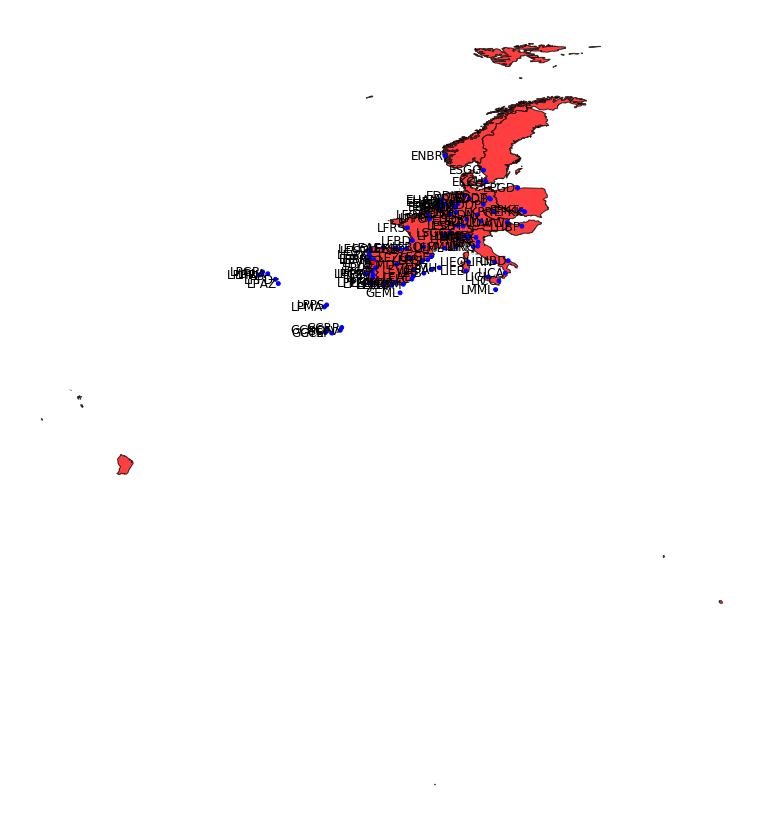

In [15]:
# Plotting map without OpenStreetMap background
fig=ax.figure
fig

# NOTE: problems with overlapping labels
# NOTE2: exclude overseas territories? The initial zoom would be better.

NOTE: Points in **blue** (served airports), point in **red** (reference airport).
<h3>5.1 Saving results</h3><br>
NOTE: The values are saved in the "reports" folder with processing date and input parameters (PCN and Runway length).

In [16]:
# Saving the shapefile of the countries served - (reports/$date+CountriesServed+PCN+Ext.shp)
basemap.to_file("reports/"+ str(datetime.now().strftime('%Y%m%d')) + "CountriesServed"+ str("PCN")+ str(namePart1) + str("Ext")+ str(namePart2) +".shp")
# Saving the shapefile of the airports served - (reports/$date+AirportsServed+PCN+Ext.shp)
coords.to_file("reports/"+ str(datetime.now().strftime('%Y%m%d')) + "AirportsServed"+ str("PCN")+ str(namePart1) + str("Ext")+ str(namePart2) +".shp")
# Saving the figure with result (overlapping labels) - (reports/$date+Result+PCN+Ext.png)
fig.savefig("reports/"+ str(datetime.now().strftime('%Y%m%d')) + "Result"+ str("PCN")+ str(namePart1) + str("Ext")+ str(namePart2) +".png", dpi=300)
# Saving the results to a csv file - (reports/$date+AirportsServed+PCN+Ext.csv)
airportsServed.to_csv("reports/"+ str(datetime.now().strftime('%Y%m%d')) + "AirportsServed"+ str("PCN")+ str(namePart1) + str("Ext")+ str(namePart2) +".csv")

<h3> 5.2 Final Comments </h3> <br>
Maintaining the current characteristics of the Viseu Aerodrome runway pavement, <b>PCN = 6.4 and runway length of 1160 meters</b>, It was possible to serve mainland Portugal, Spain and southern France. But the aircraft in operation is limited to the use of the Dornier 228, which carries only 19 passengers.

On the other hand, with <b>PCN = 23 and runway length of 1800 meters</b>, the Shengen space is served. However, it is limited to the use of aircrafts with higher operating costs per passenger, such as CRJ200 and ATR72-600 (these aircrafts carry between 50-70 passengers).

Finally, with <b>PCN = 82.2 and runway length of 2500 meters</b>, no coverage is gained (compared to previous option: PCN 23, Ext 1800), but larger aircraft (up to 200 passengers) can be used (with best cost/passenger ratio).
For example the low cost airline Ryanair only operates B737-800 aircraft (within these parameters).

<h1> References</h1>
<br>[1] Martins, J. P. F. (2018). Reflexão sobre a viabilidade e localização de uma infraestrutura aeroportuária na região Centro de Portugal (Universidade do Porto). https://doi.org/10.13140/RG.2.2.34944.69124
<br>[2] Natural Earth (2019). Free vector and raster map data at 1:10m, 1:50m, and 1:110m scales. Retrieved December 25, 2019, from http://www.naturalearthdata.com 